<a href="https://colab.research.google.com/github/anupojuharshita/Lane-Detection/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving combined_dataset (1).zip to combined_dataset (1).zip


In [ ]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K


In [ ]:
import zipfile  # ✅ Fixes the error

zip_path = "/content/combined_dataset (1).zip"
extract_path = "/mnt/data/combined_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
input_images, target_images = [], []

for file_name in sorted(os.listdir(extract_path)):
    img = cv2.imread(os.path.join(extract_path, file_name))
    if img is None: continue
    h, w = img.shape[:2]
    half_w = w // 2

    input_img = cv2.resize(img[:, :half_w], (128, 128)) / 255.0
    target_img = cv2.resize(img[:, half_w:], (128, 128)) / 255.0

    input_images.append(input_img)
    target_images.append(target_img)

input_images = np.array(input_images, dtype=np.float32)
target_images = np.array(target_images, dtype=np.float32)

X_train, X_val, y_train, y_val = train_test_split(input_images, target_images, test_size=0.1, random_state=42)


In [ ]:
def multi_scale_curve_encoder(x, filters):
    x1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x2 = layers.Conv2D(filters, 5, padding='same', activation='relu')(x)
    x3 = layers.Conv2D(filters, 7, padding='same', activation='relu')(x)
    return layers.Concatenate()([x1, x2, x3])


In [ ]:
def spatial_attention_layer():
    def layer(x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
        return x * attention
    return layer


In [ ]:
def decoder_block(x, filters):
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same', activation='relu')(x)
    x = multi_scale_curve_encoder(x, filters)
    return x


In [ ]:
def build_hsta_mce(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    x = multi_scale_curve_encoder(inputs, 32)
    x = layers.MaxPooling2D()(x)

    x = multi_scale_curve_encoder(x, 64)
    x = layers.MaxPooling2D()(x)

    # Hybrid Attention
    sa = spatial_attention_layer()(x)
    ta = temporal_attention_layer()(x)
    x = layers.Add()([sa, ta])

    # Decoder
    x = decoder_block(x, 64)
    x = decoder_block(x, 32)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)


In [ ]:
model = build_hsta_mce()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8
)


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
from tensorflow.keras.layers import Lambda

def spatial_attention_layer():
    def layer(x):
        avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(x)
        max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
        return layers.Multiply()([x, attention])
    return layer


In [ ]:
def temporal_attention_layer():
    def layer(x):
        shape = K.int_shape(x)
        h, w, c = shape[1], shape[2], shape[3]
        x_flat = layers.Reshape((h * w, c))(x)
        attention = layers.Attention()([x_flat, x_flat])
        return layers.Reshape((h, w, c))(attention)
    return layer


In [ ]:
model = build_hsta_mce()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=8)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - loss: 0.0760 - mae: 0.2468 - val_loss: 0.0593 - val_mae: 0.2141
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0494 - mae: 0.1866 - val_loss: 0.0406 - val_mae: 0.1598
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0377 - mae: 0.1516 - val_loss: 0.0349 - val_mae: 0.1422
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0347 - mae: 0.1421 - val_loss: 0.0325 - val_mae: 0.1374
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0337 - mae: 0.1397 - val_loss: 0.0306 - val_mae: 0.1321
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0308 - mae: 0.1323 - val_loss: 0.0284 - val_mae: 0.1264
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0290 - mae: 0.1272 - val_loss: 0.0274 - val_mae: 0.1241
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0275 - mae: 0.1228 - val_loss: 0.0253 - val_mae: 0.1171
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.

In [ ]:
def pixel_accuracy(y_true, y_pred, tolerance=0.05):
    return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

preds = np.clip(model.predict(X_val), 0, 1)
accuracy = pixel_accuracy(y_val, preds)

print(f"Pixel-wise Accuracy: {accuracy:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Pixel-wise Accuracy: 54.36%


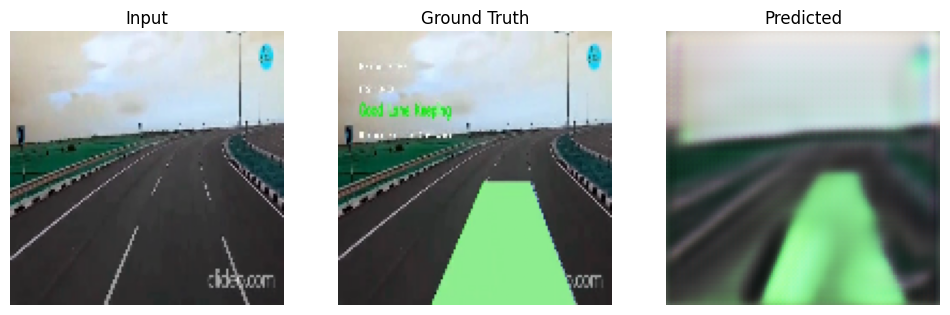

In [ ]:
i = np.random.randint(0, len(X_val))
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(X_val[i])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_val[i])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted")
plt.imshow(preds[i])
plt.axis('off')

plt.show()


In [ ]:
def sharpen_image(image):
    image = (image * 255).astype(np.uint8)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp = cv2.filter2D(image, -1, kernel)
    return sharp / 255.0


In [ ]:
def build_hsta_mce(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1 = multi_scale_curve_encoder(inputs, 32)
    p1 = layers.MaxPooling2D()(e1)

    e2 = multi_scale_curve_encoder(p1, 64)
    p2 = layers.MaxPooling2D()(e2)

    # Hybrid Attention
    sa = spatial_attention_layer()(p2)
    ta = temporal_attention_layer()(p2)
    bridge = layers.Add()([sa, ta])

    # Decoder with skip connections
    d1 = decoder_block(bridge, 64)
    d1 = layers.Concatenate()([d1, e2])

    d2 = decoder_block(d1, 32)
    d2 = layers.Concatenate()([d2, e1])

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(d2)

    return models.Model(inputs, outputs)


In [ ]:
def edge_loss(y_true, y_pred):
    sobel = tf.image.sobel_edges
    y_true_edge = sobel(y_true)
    y_pred_edge = sobel(y_pred)
    return tf.reduce_mean(tf.abs(y_true_edge - y_pred_edge))


In [ ]:
def hybrid_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred)) + 0.5 * edge_loss(y_true, y_pred)


In [ ]:
model.compile(optimizer='adam', loss=hybrid_loss, metrics=['mae'])


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[lr_scheduler, early_stop]
)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - loss: 0.1562 - mae: 0.2243 - val_loss: 0.1151 - val_mae: 0.1565 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.1122 - mae: 0.1483 - val_loss: 0.1044 - val_mae: 0.1292 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1029 - mae: 0.1300 - val_loss: 0.0986 - val_mae: 0.1214 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0976 - mae: 0.1223 - val_loss: 0.0929 - val_mae: 0.1099 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0924 - mae: 0.1138 - val_loss: 0.0903 - val_mae: 0.1007 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0874 - mae: 0.1054 - val_loss: 0.0820 - val_mae: 0.0927 - learning_rate: 0.0010
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0834 - mae: 0.0979 - val_loss: 0.0783 - val_mae: 0.0817 - learning_rate: 0.0010
Epoc

In [ ]:
def pixel_accuracy_metric(y_true, y_pred):
    tolerance = 0.05
    correct = tf.less_equal(tf.abs(y_true - y_pred), tolerance)
    return tf.reduce_mean(tf.cast(correct, tf.float32))


In [ ]:
model.compile(optimizer='adam', loss=hybrid_loss,
              metrics=['mae', pixel_accuracy_metric])


In [ ]:
def sharpen_image(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharp = cv2.filter2D((image * 255).astype(np.uint8), -1, kernel)
    return sharp / 255.0


In [ ]:
preds = np.clip(model.predict(X_val), 0, 1)
accuracy = pixel_accuracy(y_val, preds)
print(f"✅ Final Pixel-wise Accuracy: {accuracy:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
✅ Final Pixel-wise Accuracy: 89.20%


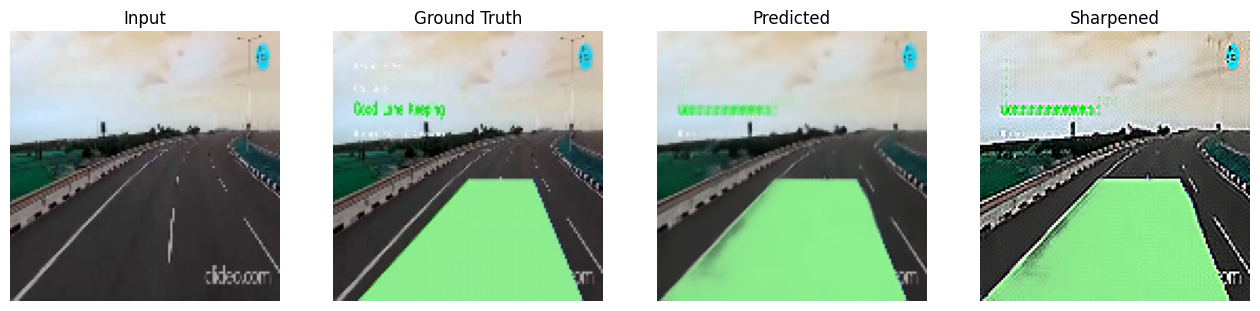

In [ ]:
def visualize_predictions(i):
    input_img = X_val[i]
    gt_img = y_val[i]
    pred_img = preds[i]
    sharp_img = sharpen_image(pred_img)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.title("Input")
    plt.imshow(input_img)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth")
    plt.imshow(gt_img)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Predicted")
    plt.imshow(pred_img)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Sharpened")
    plt.imshow(sharp_img)
    plt.axis('off')

    plt.show()

visualize_predictions(np.random.randint(len(X_val)))


In [ ]:
def plot_multiple_predictions(model, X_val, y_val, count=5, sharpen=False):
    preds = np.clip(model.predict(X_val), 0, 1)

    plt.figure(figsize=(16, 4 * count))

    for i in range(count):
        idx = np.random.randint(len(X_val))
        input_img = X_val[idx]
        gt_img = y_val[idx]
        pred_img = preds[idx]
        sharp_img = sharpen_image(pred_img) if sharpen else None

        plt.subplot(count, 4 if sharpen else 3, i * (4 if sharpen else 3) + 1)
        plt.title("Input")
        plt.imshow(input_img)
        plt.axis('off')

        plt.subplot(count, 4 if sharpen else 3, i * (4 if sharpen else 3) + 2)
        plt.title("Ground Truth")
        plt.imshow(gt_img)
        plt.axis('off')

        plt.subplot(count, 4 if sharpen else 3, i * (4 if sharpen else 3) + 3)
        plt.title("Predicted")
        plt.imshow(pred_img)
        plt.axis('off')

        if sharpen:
            plt.subplot(count, 4, i * 4 + 4)
            plt.title("Sharpened")
            plt.imshow(sharp_img)
            plt.axis('off')

    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 


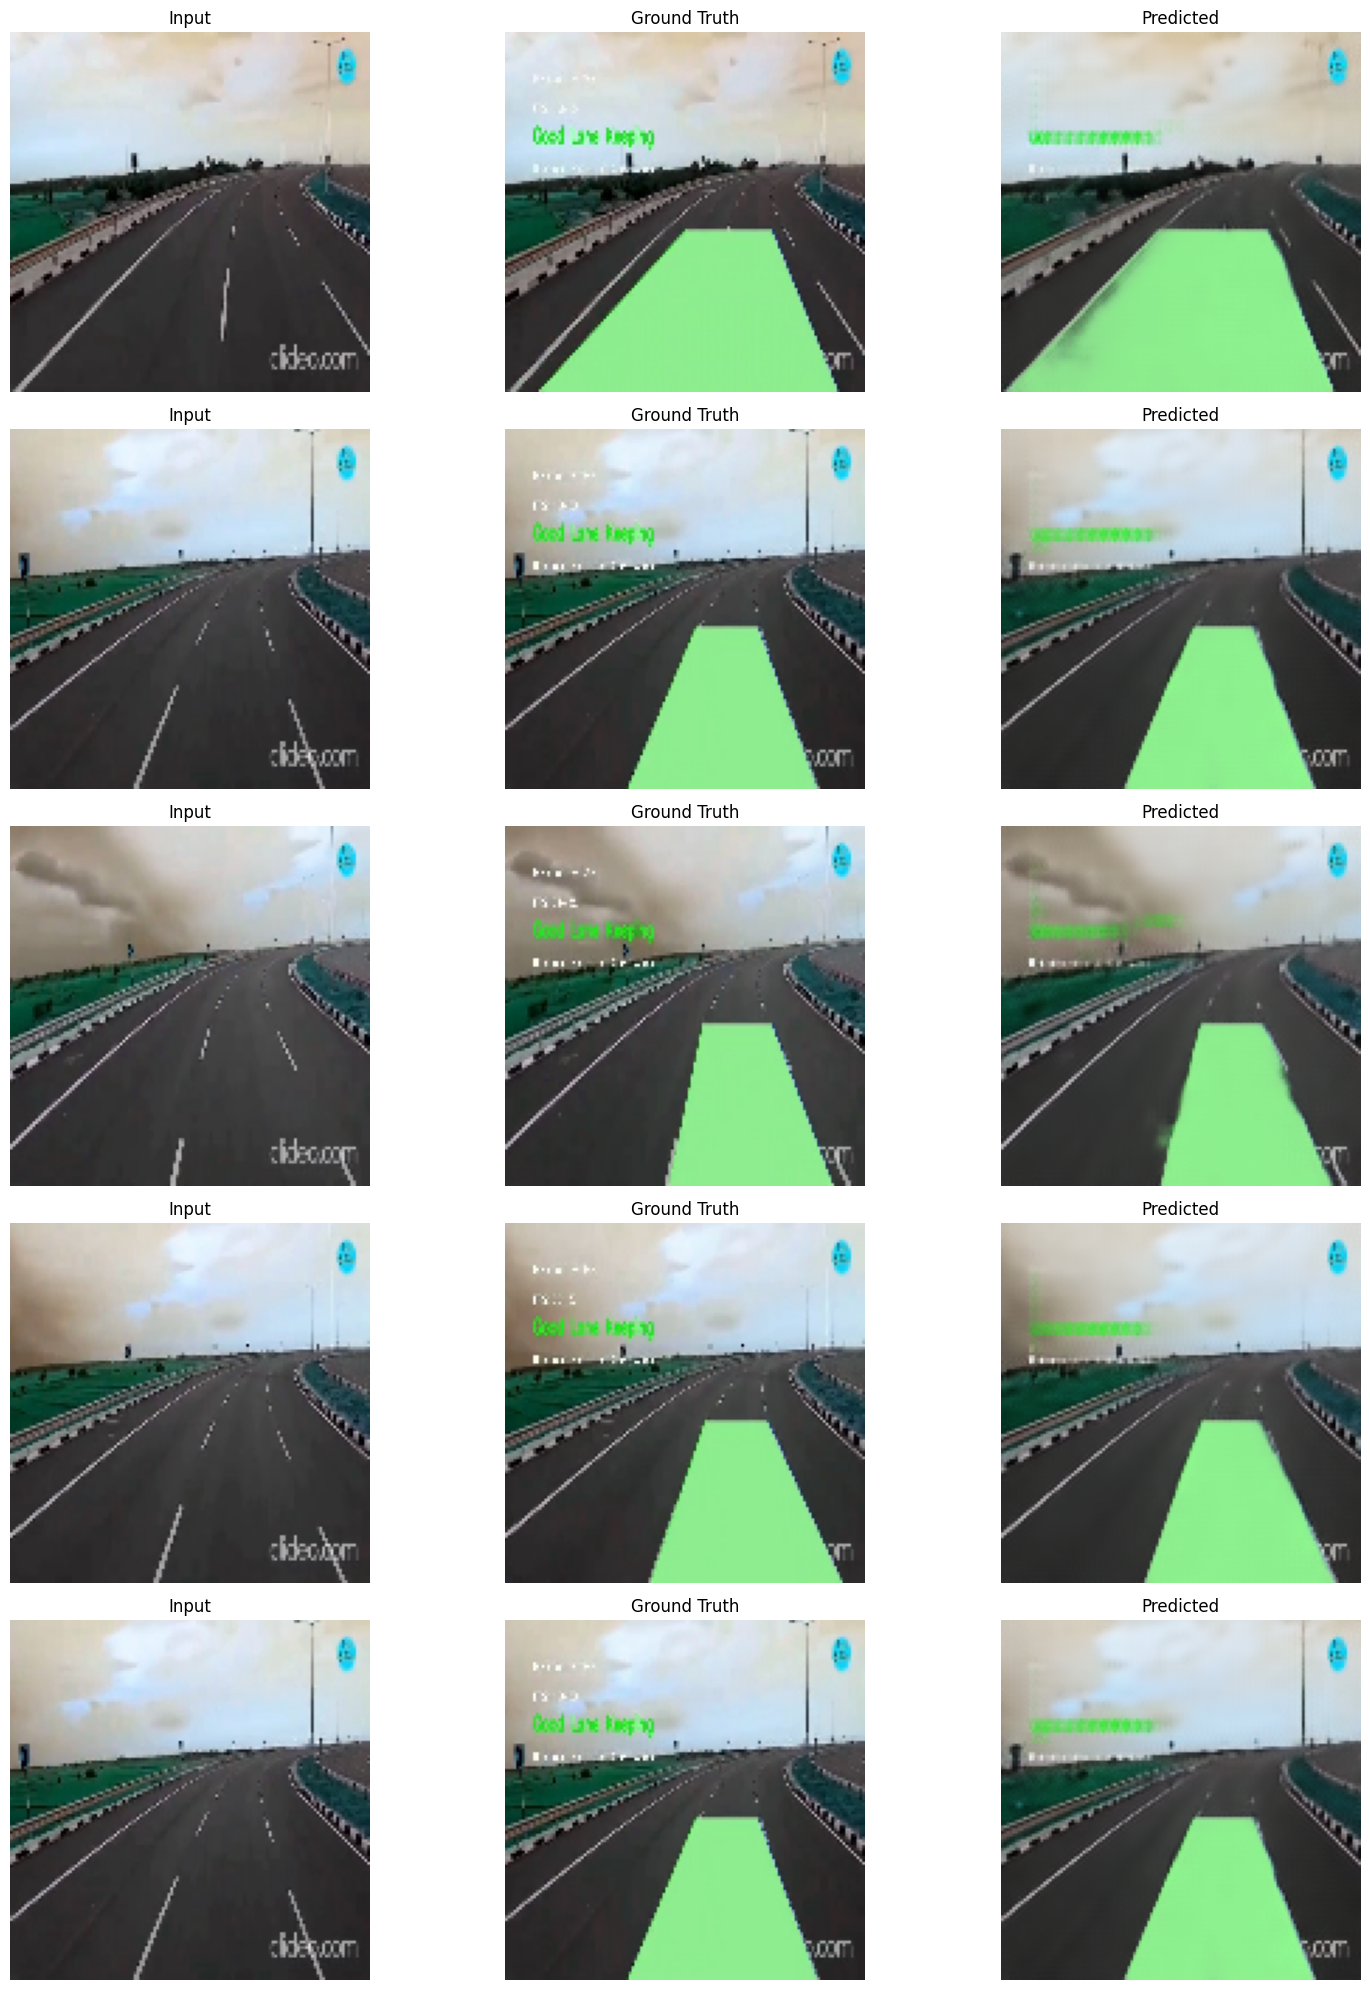

In [ ]:
plot_multiple_predictions(model, X_val, y_val, count=5, sharpen=False)
